# This is for the final model with xLSTM and dropout layers

In [ ]:
!pip install xLSTM
!pip install ninja
!pip install xlstm --force-reinstall --no-cache-dir


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: xlstm
    Found existing installation: xlstm 1.0.8
    Uninstalling xlstm-1.0.8:
      Successfully uninstalled xlstm-1.0.8


In [ ]:
import json
import torch
from torch import nn

from sklearn.model_selection import train_test_split
import time

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Hyperparameters / Variability management
DATALOADING_DATA_PATH = "/insert_file_path/all_tunes_cleaned_removed_whitespace.txt"
DATALOADING_VOCAB_PATH = "/insert_file_path/char_to_idx_truncated.json"

DATASET_SEQUENCE_LENGTH = 128
LOADER_BATCH_SIZE = 256

MODEL_EMBEDDING_DIM = 128 # Dimension of the embedding
MODEL_HIDDEN_SIZE = 256 # LSTM layer size
MODEL_LSTM_LAYERS = 4 # Number of LSTM layers
#MODEL_SAVE_PATH =   '/content/drive/MyDrive/Model weights/LIGHTWEIGHT_xLSTM_DropOut_NoWhiteSpace.pt'

TRAINING_EPOCHS = 15

#RESULTS_LOAD_PATH =  '/content/drive/MyDrive/Deep learning/Model weights/final_model_weights.pt'

In [ ]:
with open(DATALOADING_DATA_PATH, "r") as f:
  data = f.read()

with open(DATALOADING_VOCAB_PATH) as f:
    char_to_index = json.load(f)
    index_to_char = {index: char for char, index in char_to_index.items()} # To transfer back

In [ ]:
data_translated = [char_to_index[char] for char in data]
data_translated = data_translated[:len(data_translated) // 250] # Truncate data

In [ ]:
# Define the data set
# WARNING: TAKES TRANSLATED DATA FORMAT
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self,
                 X, # The data in TRANSLATED FORMAT
                 sequence_len=1, # How much context does the model have?
                 ):

        self.X=torch.tensor(X, dtype=torch.long)
        self.sequence_len=sequence_len

    def __len__(self):
      # Make room for a last sequence and its target, hence the 1 also
        return len(self.X) - self.sequence_len - 1


    def __getitem__(self,idx):
        X = self.X[idx:idx+self.sequence_len] # 1 x sequence_len
        Ytarget = self.X[idx+self.sequence_len] # 1 x 1
        return X, Ytarget.long() # For dimensions to match LSTM layer :)

In [ ]:
dataset = MusicDataset(X=data_translated, sequence_len=DATASET_SEQUENCE_LENGTH)

train_idx, test_idx = train_test_split(range(len(dataset)), test_size=.1, shuffle=False)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

In [ ]:
import torch
from torch import nn
from xlstm import xLSTMBlockStack, xLSTMBlockStackConfig, mLSTMBlockConfig, mLSTMLayerConfig, sLSTMBlockConfig, sLSTMLayerConfig, FeedForwardConfig

class SimpleModelWithxLSTM(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_dim,
                 hidden_size,
                 context_length,
                 num_blocks,
                 slstm_at,
                 dropout_prob = 0.5):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )


        # xLSTM configuration
        self.xLSTM_cfg = xLSTMBlockStackConfig(
            mlstm_block=mLSTMBlockConfig(
                mlstm=mLSTMLayerConfig(
                    conv1d_kernel_size=4,
                    qkv_proj_blocksize=4,
                    num_heads=4
                )
            ),
            slstm_block=sLSTMBlockConfig(
                slstm=sLSTMLayerConfig(
                    backend="cuda",
                    num_heads=4,
                    conv1d_kernel_size=4,
                    bias_init="powerlaw_blockdependent",
                ),
                feedforward=FeedForwardConfig(
                    proj_factor=1.3,
                    act_fn="gelu"
                ),
            ),
            context_length=context_length,
            num_blocks=num_blocks,
            embedding_dim=embedding_dim,
            slstm_at=slstm_at,
        )

        # Initialize xLSTM stack
        self.xLSTM = xLSTMBlockStack(self.xLSTM_cfg)

        self.dropout_1 = nn.Dropout(dropout_prob)


        # Fully connected layers
        self.fc1 = nn.Linear(embedding_dim, hidden_size)
        self.dropout_2 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, vocab_size)


    def forward(self, x):
        # Embed the input
        x = self.embedding(x)  # Shape: [batch_size, seq_length, embedding_dim]

        # Pass through the xLSTM stack
        x = self.xLSTM(x)  # Shape: [batch_size, seq_length, embedding_dim]

        x = self.dropout_1(x)
        # Take the last sequence step (e.g., for classification tasks)
        x = x[:, -1, :]  # Shape: [batch_size, embedding_dim]

        # Fully connected layers
        x = self.fc1(x)  # Shape: [batch_size, hidden_size]
        x = nn.functional.relu(x)
        x = self.dropout_2(x)
        x = self.fc2(x)  # Shape: [batch_size, vocab_size]

        return x

In [ ]:
VOCAB_SIZE = len(char_to_index)
EMBEDDING_DIM = MODEL_EMBEDDING_DIM
HIDDEN_SIZE = MODEL_HIDDEN_SIZE
CONTEXT_LENGTH = DATASET_SEQUENCE_LENGTH
NUM_BLOCKS = 7  # Number of xLSTM blocks
SLSTM_AT = [1]  # Use sLSTM at specific layers

# Initialize the model
model = SimpleModelWithxLSTM(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=HIDDEN_SIZE,
    context_length=CONTEXT_LENGTH,
    num_blocks=NUM_BLOCKS,
    slstm_at=SLSTM_AT
).to(device)


n_epochs = TRAINING_EPOCHS

loss_fn = nn.CrossEntropyLoss() # Because character classification task
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

load_path = "/insert_file_path/Final_Model_xLSTM_Truncated_NoWhiteSpace.pt"
model.load_state_dict(torch.load(load_path, weights_only=True, map_location=torch.device('cpu')))

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/usr/local/lib/python3.10/di

<All keys matched successfully>

In [ ]:
batch_size = LOADER_BATCH_SIZE


train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
# TEST EVAL RUN
model.eval()
predictions = []

with torch.no_grad():
    for batch_number, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)

        print(f"Batch {batch_number + 1}/{len(test_loader)}")

        predictions.append((y_pred.argmax(dim=1), y_batch))

Batch 1/73
Batch 2/73
Batch 3/73
Batch 4/73
Batch 5/73
Batch 6/73
Batch 7/73
Batch 8/73
Batch 9/73
Batch 10/73
Batch 11/73
Batch 12/73
Batch 13/73
Batch 14/73
Batch 15/73
Batch 16/73
Batch 17/73
Batch 18/73
Batch 19/73
Batch 20/73
Batch 21/73
Batch 22/73
Batch 23/73
Batch 24/73
Batch 25/73
Batch 26/73
Batch 27/73
Batch 28/73
Batch 29/73
Batch 30/73
Batch 31/73
Batch 32/73
Batch 33/73
Batch 34/73
Batch 35/73
Batch 36/73
Batch 37/73
Batch 38/73
Batch 39/73
Batch 40/73
Batch 41/73
Batch 42/73
Batch 43/73
Batch 44/73
Batch 45/73
Batch 46/73
Batch 47/73
Batch 48/73
Batch 49/73
Batch 50/73
Batch 51/73
Batch 52/73
Batch 53/73
Batch 54/73
Batch 55/73
Batch 56/73
Batch 57/73
Batch 58/73
Batch 59/73
Batch 60/73
Batch 61/73
Batch 62/73
Batch 63/73
Batch 64/73
Batch 65/73
Batch 66/73
Batch 67/73
Batch 68/73
Batch 69/73
Batch 70/73
Batch 71/73
Batch 72/73
Batch 73/73


In [ ]:
character_labels = [index_to_char[i] for i in range(len(index_to_char))]

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Assuming your predictions list has data in the form [(predicted, actual), ...]
all_preds = []
all_actuals = []

# Flattening predictions across all batches
for preds, actuals in predictions:
    all_preds.extend(preds.cpu().numpy())
    all_actuals.extend(actuals.cpu().numpy())
    for preds in all_preds:
      if preds == 10:
        print("what the skibidi")

all_preds = [index_to_char[index] for index in all_preds]
all_actuals = [index_to_char[index] for index in all_actuals]



unique_labels = sorted(list(set(all_actuals + all_preds)))

# Compute confusion matrix
conf_matrix = confusion_matrix(all_actuals, all_preds, labels = unique_labels, normalize="true")

In [ ]:
with open("/insert_file_path/predictions.json", "w") as f:
    json.dump((all_preds, all_actuals), f)


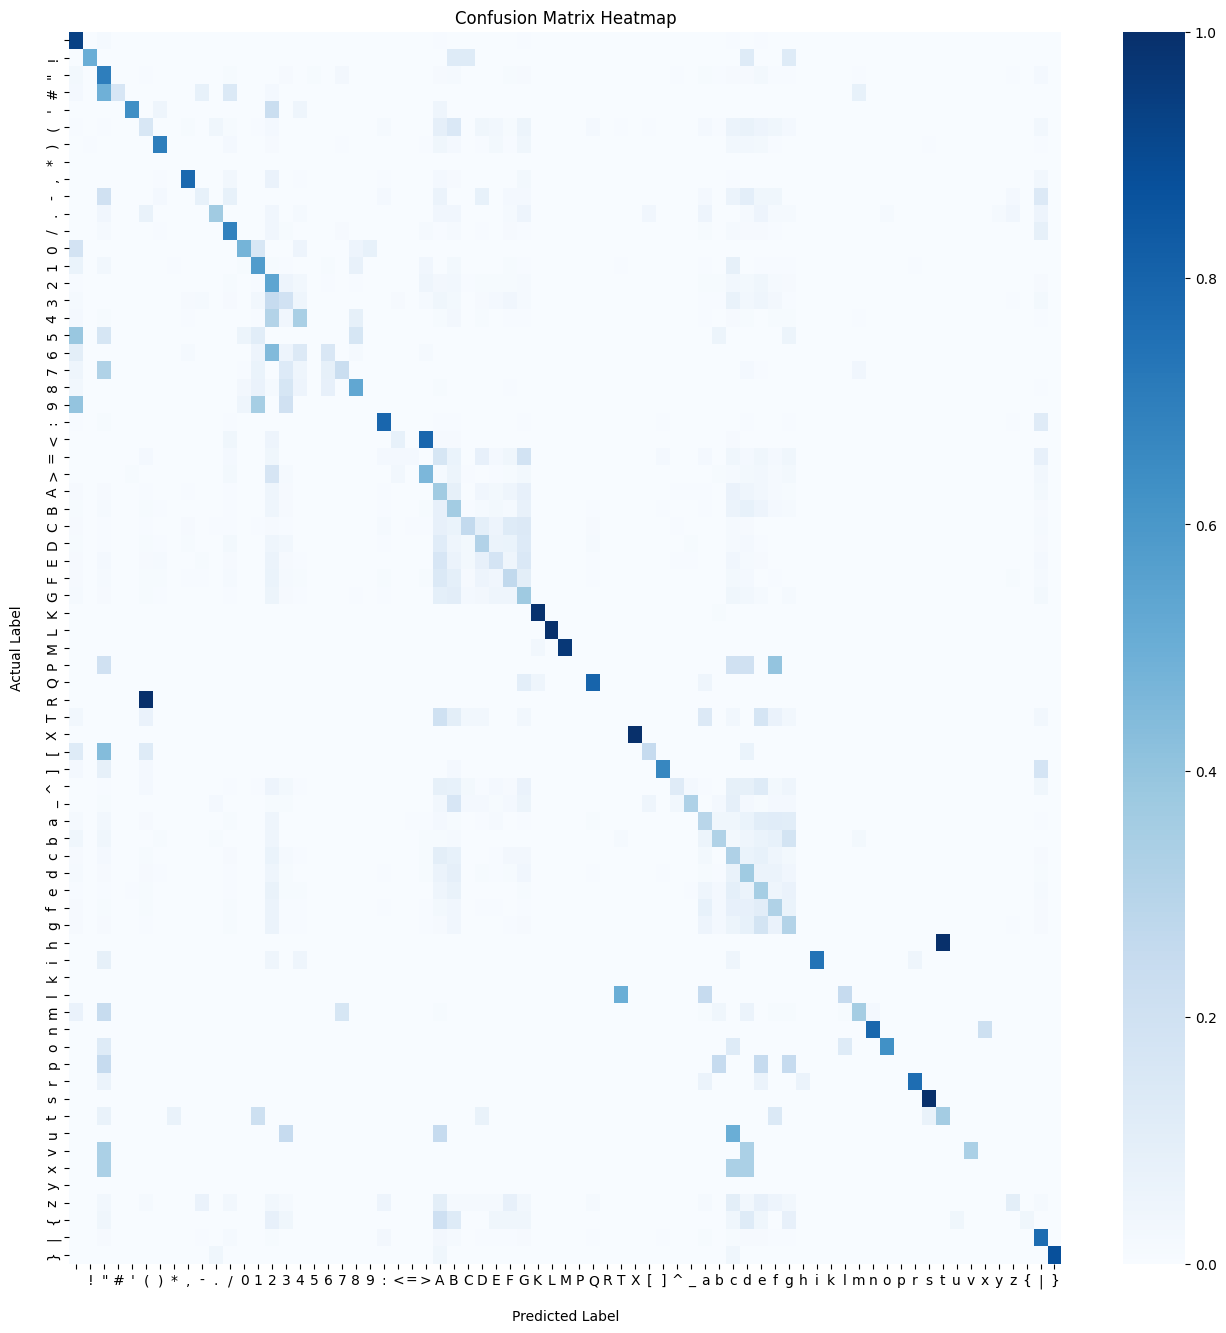

In [ ]:
# Visualize confusion matrix as heatmap
plt.figure(figsize=(16, 16))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Blues',
            xticklabels=unique_labels,
            yticklabels=unique_labels)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix Heatmap')
plt.show()